In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
torch.manual_seed(0)
np.random.seed(0)
import pandas as pd
import glob
import re
import math
import os

In [2]:
# velocity 0.00002 of axis at time 0
velocity_profile_dir_1 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_five/velocity_profile/'
file_name_list = []
velocity_temp = pd.DataFrame({"x_axis":[""],"y_velocity":[""]})

for root, dirs, files in os.walk(velocity_profile_dir_1, topdown = True):
    for filename in files:
        file_name_list.append(os.path.join(root, filename))
file_name_list = file_name_list[1:]   
for file in file_name_list:
    temp = pd.read_csv(file,skiprows=4)
    temp.columns=['x_axis','y_velocity']
    velocity_temp = pd.concat([velocity_temp,temp],axis=0).reset_index(drop=True)
velocity_00002_step = velocity_temp.drop(0)     
x_axis = velocity_00002_step['x_axis'].values
x_axis = x_axis.astype(float) 
x_axis = torch.from_numpy(x_axis).float().reshape(-1,100,1)
y_velocity = velocity_00002_step['y_velocity'].values
y_velocity = y_velocity.astype(float) 
y_velocity = torch.from_numpy(y_velocity).float().reshape(-1,100)

x_train  = x_axis        # x-axis value 
y_train  = y_velocity    # y-velocity


x_axis_test = velocity_00002_step['x_axis'].values
x_axis_test = x_axis_test.astype(float) 
x_axis_test = torch.from_numpy(x_axis_test).float().reshape(-1,100,1)
y_velocity_test = velocity_00002_step['y_velocity'].values
y_velocity_test = y_velocity_test.astype(float) 
y_velocity_test = torch.from_numpy(y_velocity_test).float().reshape(-1,100)

x_test = x_axis_test
y_test = y_velocity_test


In [3]:
# velocity 0.0009 of axis at time 900
velocity_profile_dir_2 = '/Users/jianbinlin/Documents/Master-Data-Spreadsheet/data/velocity_profile/oct_seventy_five/velocity_profile_one/velocity_profile'
file_name_list = []
velocity_temp = pd.DataFrame({"x_axis":[""],"y_velocity":[""]})

for root, dirs, files in os.walk(velocity_profile_dir_2, topdown = True):
    for filename in files:
        file_name_list.append(os.path.join(root, filename)) #
file_name_list = file_name_list[1:]   
for file in file_name_list:
    temp = pd.read_csv(file,skiprows=4)
    temp.columns=['x_axis','y_velocity']
    velocity_temp = pd.concat([velocity_temp,temp],axis=0).reset_index(drop=True)

velocity_0009_step = velocity_temp.drop(0)       

# x_axis = velocity_0009_step['x_axis'].values
# x_axis = x_axis.astype(float) 
# x_axis = torch.from_numpy(x_axis).float().reshape(-1,100,1)
# y_velocity = velocity_0009_step['y_velocity'].values
# y_velocity = y_velocity.astype(float) 
# y_velocity = torch.from_numpy(y_velocity).float().reshape(-1,100)


x_axis_test = velocity_0009_step['x_axis'].values
x_axis_test = x_axis_test.astype(float) 
x_axis_test = torch.from_numpy(x_axis_test).float().reshape(-1,100,1)
y_velocity_test = velocity_0009_step['y_velocity'].values
y_velocity_test = y_velocity_test.astype(float) 
y_velocity_test = torch.from_numpy(y_velocity_test).float().reshape(-1,100)

# x_train  = x_axis
# y_train  = y_velocity
x_test = x_axis_test
y_test = y_velocity_test


In [4]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1          # Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)  # each number has its own corresponding fourier cofficicent

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        # self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) #why it is 2??
        self.fc0 = nn.Linear(1, self.width)   # linear transformation layer
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1) # first Fourier layer 
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)
        # self.double()

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = self.fc0(x)          # first layer is fully-connected layer 
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x) # activation function => linear activation function
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)  #there is no activation function in FNO

In [5]:
# batch_size = 1
# learning_rate = 0.001
# epochs = 5
# step_size = 50
# gamma = 0.5
# modes = 16
# width = 64


In [6]:
ntrain = 5
ntest = 5
sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h
s=128
batch_size = 20
learning_rate = 0.001
epochs = 500    
step_size = 50
gamma = 0.5
modes = 16
width = 64

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [7]:
# 1D burger training and validate
learning_rate = 0.001 
modes = 16 #
width = 64 # why conv1 channel is 64??
# model = FNO1d(modes, width).cuda() # use cude if GPU available
model = FNO1d(modes, width)          #
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) #initiate the adam optimizer instance
step_size = 50
gamma = 0.5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
# 1D burger training and validate continue
myloss         = LpLoss(size_average=False)  # the output of LPLoss is normalized y value, does not return a normalized x value
epochs         = 100
train_mse_list = []
train_l2_list  = []
test_l2_list   = []


for ep in range(epochs):
    model.train()     #while calling torch built-in train() method, a built-in function of model,
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
    #   x, y = x.cuda(), y.cuda()
      optimizer.zero_grad() # zero model parameter gradient from previous training step, otherwise it used previous step carrying put training
      out = model(x) # calling the forward function of the model => forward(self, x) or model.forward(x), pytorch overides __call__function, so no need explicit call .forward fucntion.
      mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean') # F refers to torch.nn.functional, a tensor that contains multiple training data point
      l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1)) # a tuple
      l2.backward() # compute the gradient by calling backward() function
      optimizer.step() # update the model's parameter after computring gradient
      train_mse += mse.item() # get scalar value of each data points
      train_l2 += l2.item()   # obtain single scalar value of each loss
    scheduler.step()   #to update the learning rate
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
           # x, y = x.cuda(), y.cuda()
            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)   
    train_mse_list.append(train_mse)
    train_l2_list.append(train_l2)
    test_l2_list.append(test_l2)


0 0.5980074590188451 0.0007892973593698116 50.089531373977664 57.807244062423706
1 0.5534576670033857 3.383402067811403e-05 11.56720724105835 108.50254878997802
2 0.5564767080359161 2.1773670823677094e-05 9.223530197143555 108.60249729156494
3 0.5681970419827849 1.4463994830293814e-05 7.2924432277679445 84.14918746948243
4 0.5592450840049423 7.277807935679448e-06 5.473823165893554 90.11496114730835
5 0.5525234580272809 6.900636981299612e-06 5.306679201126099 93.21429176330567
6 0.5524596250033937 7.236363580886973e-06 5.394428157806397 95.5323613166809
7 0.545771999983117 9.19187505132868e-06 5.967984008789062 93.60821437835693
8 0.5589783340110444 7.022581962701225e-06 5.191554141044617 77.86361646652222
9 0.5626134580234066 1.0188317719439511e-05 6.205026149749756 93.1145001411438
10 0.5543332080123946 7.573201719424105e-06 5.49554557800293 91.03933391571044
11 0.5620853340369649 9.086719137485488e-06 5.864693546295166 85.06408433914184
12 0.6446362920105457 7.623638111908804e-06 5.6

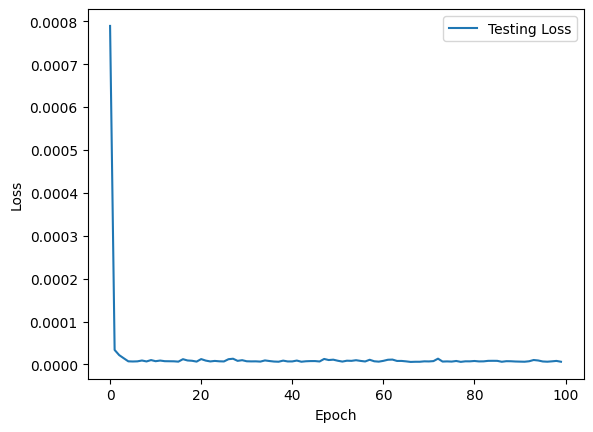

In [14]:
plt.plot(train_mse_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

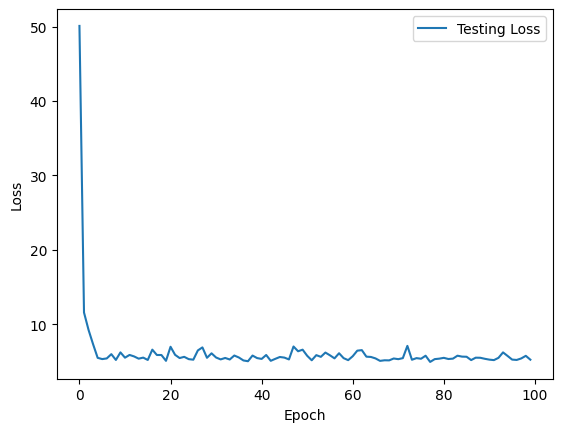

In [15]:
plt.plot(train_l2_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

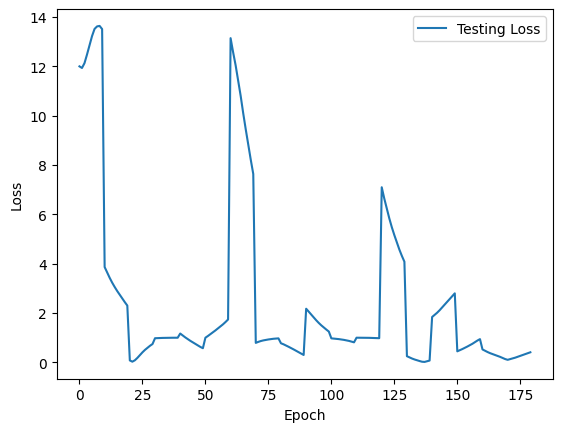

In [16]:
plt.plot(test_l2_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

0 11.998976707458496
1 11.933550834655762
2 12.128927230834961
3 12.478424072265625
4 12.845717430114746
5 13.227227210998535
6 13.518259048461914
7 13.620004653930664
8 13.639399528503418
9 13.511934280395508
10 3.860950231552124
11 3.639622211456299
12 3.4232771396636963
13 3.226357936859131
14 3.0497689247131348
15 2.885631561279297
16 2.7339229583740234
17 2.5898866653442383
18 2.438120126724243
19 2.2977371215820312
20 0.07314833998680115
21 0.022258562967181206
22 0.07892805337905884
23 0.17578202486038208
24 0.2904985249042511
25 0.40061643719673157
26 0.4996287226676941
27 0.5848017334938049
28 0.6667844653129578
29 0.7371854782104492
30 0.9732424020767212
31 0.9782218337059021
32 0.9828729629516602
33 0.9859383702278137
34 0.988545298576355
35 0.9902878999710083
36 0.9918564558029175
37 0.9930471777915955
38 0.9934874176979065
39 0.9936439990997314
40 1.1637694835662842
41 1.0846785306930542
42 1.0078495740890503
43 0.9366308450698853
44 0.8689321279525757
45 0.806260704994201

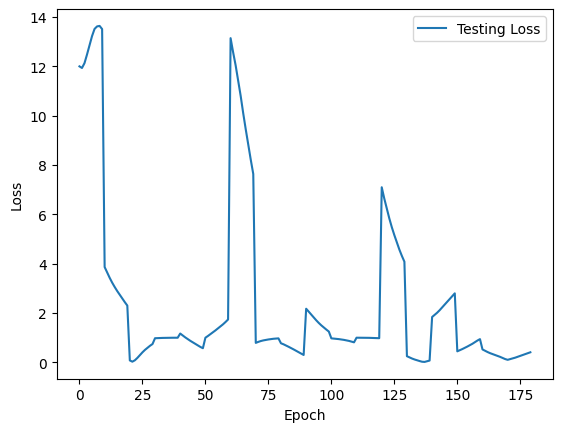

In [17]:
pred = torch.zeros(y_test.shape)
index = 0
test_l2_list   = []
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # x, y = x.cuda(), y.cuda()
        out = model(x).view(-1)
        pred[index] = out
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1
        test_l2_list.append(test_l2)
plt.plot(test_l2_list, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
